In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import read_table

In [2]:
df_bat = read_table("PlayerBatting")
df_bat = df_bat.drop(columns=["Unnamed: 0"])

In [3]:
df_bat["PA"] = df_bat["AB"] + df_bat["BB"] + df_bat["IBB"] + df_bat["HBP"]
df_bat["1B"] = df_bat["H"] - df_bat["2B"] - df_bat["3B"] - df_bat["HR"]

In [4]:
# On base percentage: BB + IBB + HBP + H / PA
# H - 2B - 3B - HR = 1B
# slugging: (total number of bases per AB on average) 1B + 22B + 33B + 4HR / AB

# On-base + slugging: Adding them together (OPS)
df_bat["OnBaseP"] = (df_bat["BB"] + df_bat["IBB"] + df_bat["HBP"] + df_bat["H"]) / df_bat["PA"]
df_bat["Slugging"] = (df_bat["1B"] + 2*df_bat["2B"] + 3*df_bat["3B"] + 4*df_bat["HR"]) / df_bat["AB"]
df_bat["OPS"] = df_bat["OnBaseP"] + df_bat["Slugging"] 

In [5]:
# Create the NextYearOPS column that contains for every row the OPS value for next year.
# For a player's last year, the value is set to NaN and the row is deleted afterwards.

df_bat_temp = df_bat[["playerID", "yearID", "OPS"]]
OPS = df_bat_temp["OPS"].shift(-1)
players = df_bat_temp["playerID"]
for i in range(0, len(OPS) - 1):
    if players[i] != players[i+1]:
        OPS[i] = np.nan
df_bat["NextYearOPS"] = OPS
df_bat = df_bat.dropna(subset=['NextYearOPS', 'AB', 'PA', 'OPS', 'Slugging', 'OnBaseP'])
df_bat = df_bat.reset_index()
df_bat["OPS_will_increase"] = df_bat["NextYearOPS"] > df_bat["OPS"]

In [7]:
def find_cutoff_index(playerIDlist, test_ratio):
    # returns a correct index for cutting off training and test data, must include the index in training data
    if not (test_ratio < 1 and test_ratio > 0): return Exception("Fuck you")
    approx_index = int(len(playerIDlist) * (1 - test_ratio))
    approx_index_is_correct = playerIDlist[approx_index] != playerIDlist[approx_index + 1]
    while not approx_index_is_correct:
        approx_index += 1
        approx_index_is_correct = playerIDlist[approx_index] != playerIDlist[approx_index + 1]
    return approx_index

split_index = find_cutoff_index(df_bat["playerID"].tolist(), 0.15)

In [8]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

from sklearn.tree import DecisionTreeClassifier, plot_tree

In [9]:
df_reg_bat = df_bat.drop(columns=["index", "playerID", "stint", "teamID", "lgID", "birthYear", "debut", "NextYearOPS", "OPS_will_increase"])
df_reg_bat = df_reg_bat.drop(columns=["OPS", "Slugging", "OnBaseP"])
targets = df_bat["NextYearOPS"]

train_df = np.array(df_reg_bat[:split_index])
test_df = np.array(df_reg_bat[split_index:])

train_targets = np.array(targets[:split_index])
test_targets = np.array(targets[split_index:])

In [10]:
# a stupid model that predicts a player will keep the same OPS as last year
class StupidRegressionBaseline():
    def predict(self, test_df):
        return test_df[:, -1]

baseline = StupidRegressionBaseline()
y_pred_baseline = baseline.predict(test_df)
mse = mean_squared_error(test_targets, y_pred_baseline)
print("mse: ", mse)

mse:  4608.341099521589


In [11]:
# the random forests performs a little better than the stupid baseline!
rf_regressor = RandomForestRegressor(n_estimators=69)
rf_regressor.fit(train_df, train_targets)
y_pred = rf_regressor.predict(test_df)
mse = mean_squared_error(test_targets, y_pred)
print("mse: ", mse)

mse:  0.017633783334938386


In [12]:
importances = rf_regressor.feature_importances_
feature_names = df_reg_bat.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

,Feature,Importance
7,HR,0.171424
11,BB,0.060739
0,yearID,0.059870
1,G,0.058680
12,SO,0.055905
8,RBI,0.046596
18,weight,0.044679
3,R,0.044449
20,current_age,0.043107
21,years_of_experience,0.038380


In [13]:
df_clf_bat = df_reg_bat
targets = df_bat["OPS_will_increase"]

train_df = np.array(df_clf_bat[:split_index])
test_df = np.array(df_clf_bat[split_index:])

train_targets = np.array(targets[:split_index])
test_targets = np.array(targets[split_index:])

In [14]:
class StupidClassificationBaseline():
    def __init__(self) -> None:
        majority_class = False
    def fit(self, _, train_targets):
        self.majority_class = np.bincount(train_targets).argmax()
    def predict(self, test_df):
        return np.full(len(test_df), self.majority_class)
    
    
baseline = StupidClassificationBaseline()
baseline.fit(train_df, train_targets)
y_pred_baseline = baseline.predict(test_df)
acc = accuracy_score(test_targets, y_pred_baseline)
print("Accuracy: ", acc)

Accuracy:  0.5314685314685315


In [15]:
rf_classifier = RandomForestClassifier(n_estimators=69)
rf_classifier.fit(train_df, train_targets)
y_pred = rf_classifier.predict(test_df)
acc = accuracy_score(test_targets, y_pred)
print("Accuracy: ", acc)


Accuracy:  0.6417428725121033


In [16]:
importances = rf_classifier.feature_importances_
feature_names = df_clf_bat.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

,Feature,Importance
2,AB,0.065502
4,H,0.064985
22,PA,0.061098
8,RBI,0.054929
12,SO,0.052544
1,G,0.051838
23,1B,0.051628
3,R,0.049096
5,2B,0.047868
0,yearID,0.047000


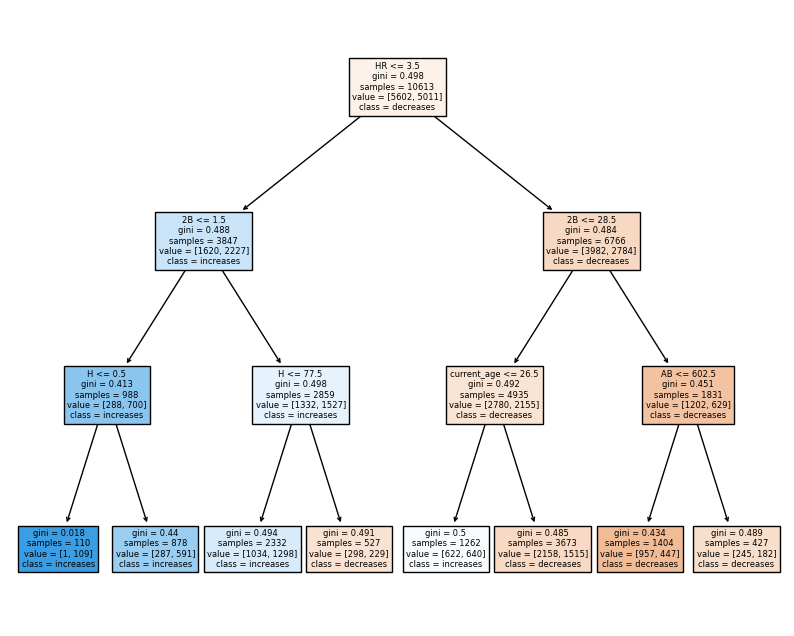

In [22]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(train_df, train_targets)

plt.figure(figsize=(10, 8))
plot_tree(clf, feature_names=df_clf_bat.columns, class_names=["decreases", "increases"], filled=True)
plt.show()

In [20]:
y_pred = clf.predict(test_df)
accuracy_score(y_pred, test_targets)

0.5895642818719742